# Linear Regression of Relative Humidity Data from Mars Curiosity Rover
### Here are the main steps involved in the code:
1. Import data from website.
2. Run linear regression tests using data from each epoch, which was split into different folders on the website. This was done due to computational limits for the entire set of 2358 sols. 
3. Repeat linear regression for all epochs. Find average of R^2 values across all epochs at the end.
4. Plots from poster were made using data from Sols 1063-1159.
5. Note: Since kernels kept crashing, periodic print statements were added to continue running the code. 


In [2]:
import urllib3
import urllib.request
import numpy as np
from bs4 import BeautifulSoup #https://stackoverflow.com/questions/11023530/python-to-list-http-files-and-directories
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import datasets, linear_model
from sklearn import metrics

column_names = {'local_relative_humidity': 30, 'local_relative_humidity_uncertainty': 32}    
base_url = 'https://atmos.nmsu.edu/PDS/data/mslrem_1001/DATA/'
sol_epoch_starts = np.array([1, 90, 180, 270, 360, 450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])
# num_epochs = sol_epoch_starts.size - 1
num_epochs = 1

def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

def get_epoch_name(index):
    string1 = str(sol_epoch_starts[index]) 
    string2 = str(sol_epoch_starts[index+1] - 1)
    string1 = '0' * (5 - len(string1)) + string1    
    string2 = '0' * (5 - len(string2)) + string2
    entire_string = 'SOL_' + string1 + '_' + string2
    return entire_string  

def get_sol_name(sol_num):
    string = str(sol_num)
    string = 'SOL' + '0' * (5 - len(string)) + string
    return string

http = urllib3.PoolManager()
r2_temp1s = []
temp1_accuracies = []
r2_temp2s = []
temp2_accuracies = []
r2_ambtemps = []
ambtemp_accuracies = []
r2_alltemps = []
alltemps_accuracies = []
r2_pressures = []
press_accuracies = []
r2_alls = []
all_accuracies = []

lm = linear_model.LinearRegression() 

In [2]:
#1-89 Sols
sol_epoch_starts = np.array([1, 90, 180, 270, 360, 450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("1-89 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

1-89 Sols
R^2 for Boom 1 Temperature: 0.608591468035422
R^2 for Boom 2 Temperature: 0.7253220904412425
R^2 for Ambient Temperature: 0.579687781461556
R^2 for Pressure: -0.16808231688484815
R^2 for All Temperatures: 0.732016063124501
R^2 for All: 0.7349206545334027


In [3]:
#90-179 Sols
sol_epoch_starts = np.array([90, 180, 270, 360, 450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("90-179 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

90-179 Sols
R^2 for Boom 1 Temperature: 0.7780524600334561
R^2 for Boom 2 Temperature: 0.7857673344938957
R^2 for Ambient Temperature: 0.8059427540060963
R^2 for Pressure: 0.1130024787741896
R^2 for All Temperatures: 0.8155162196018726
R^2 for All: 0.8146709493994164


In [4]:
print(r2_temp1s, temp1_accuracies, r2_temp2s, temp2_accuracies, r2_ambtemps, ambtemp_accuracies, r2_alltemps, alltemps_accuracies, r2_pressures, press_accuracies, r2_alls, all_accuracies)

[0.608591468035422, 0.7780524600334561] [0.5775130084264942, 0.7784553737973955] [0.7253220904412425, 0.7857673344938957] [0.7273187092900053, 0.7854490245517289] [0.579687781461556, 0.8059427540060963] [0.561429535014186, 0.8053650172980267] [0.732016063124501, 0.8155162196018726] [0.7266685579493631, 0.8150924530496848] [-0.16808231688484815, 0.1130024787741896] [-0.029292459284214756, 0.11837212609603187] [0.7349206545334027, 0.8146709493994164] [0.73092787165723, 0.8142324336063692]


In [5]:
#180-269 Sols
sol_epoch_starts = np.array([180, 270, 360, 450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("180-269 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

180-269 Sols
R^2 for Boom 1 Temperature: 0.6297613811437551
R^2 for Boom 2 Temperature: 0.7197980282879539
R^2 for Ambient Temperature: 0.6763643928758349
R^2 for Pressure: -0.09351806979996109
R^2 for All Temperatures: 0.7195087373612029
R^2 for All: 0.7415246257171251


In [6]:
#270-359 Sols
sol_epoch_starts = np.array([270, 360, 450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("270-359 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

270-359 Sols
R^2 for Boom 1 Temperature: 0.7266205965891404
R^2 for Boom 2 Temperature: 0.7182844872239051
R^2 for Ambient Temperature: 0.7488852421926011
R^2 for Pressure: 0.4096147808118172
R^2 for All Temperatures: 0.7736953282509502
R^2 for All: 0.7797936574194793


In [7]:
print(r2_temp1s, temp1_accuracies, r2_temp2s, temp2_accuracies, r2_ambtemps, ambtemp_accuracies, r2_alltemps, alltemps_accuracies, r2_pressures, press_accuracies, r2_alls, all_accuracies)

[0.608591468035422, 0.7780524600334561, 0.6297613811437551, 0.7266205965891404] [0.5775130084264942, 0.7784553737973955, 0.6772839800361711, 0.7334026873852226] [0.7253220904412425, 0.7857673344938957, 0.7197980282879539, 0.7182844872239051] [0.7273187092900053, 0.7854490245517289, 0.7540812991210603, 0.7232635486132208] [0.579687781461556, 0.8059427540060963, 0.6763643928758349, 0.7488852421926011] [0.561429535014186, 0.8053650172980267, 0.7168747194047624, 0.7540097939871565] [0.732016063124501, 0.8155162196018726, 0.7195087373612029, 0.7736953282509502] [0.7266685579493631, 0.8150924530496848, 0.754291767615253, 0.78007161896674] [-0.16808231688484815, 0.1130024787741896, -0.09351806979996109, 0.4096147808118172] [-0.029292459284214756, 0.11837212609603187, 0.06182312929856093, 0.439807541438196] [0.7349206545334027, 0.8146709493994164, 0.7415246257171251, 0.7797936574194793] [0.73092787165723, 0.8142324336063692, 0.7669362281063445, 0.7860439759654456]


In [8]:
#360-449 Sols
sol_epoch_starts = np.array([360, 450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("360-449 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

360-449 Sols
R^2 for Boom 1 Temperature: 0.7006012882021174
R^2 for Boom 2 Temperature: 0.7106241527597474
R^2 for Ambient Temperature: 0.6930407077531203
R^2 for Pressure: 0.38838825216393225
R^2 for All Temperatures: 0.7822235696781235
R^2 for All: 0.7817891293818681


In [9]:
#450-583 Sols
sol_epoch_starts = np.array([450, 584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("450-583 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

450-583 Sols
R^2 for Boom 1 Temperature: 0.5751796271984406
R^2 for Boom 2 Temperature: 0.5277207670020225
R^2 for Ambient Temperature: 0.54917509899962
R^2 for Pressure: -0.09886447948533053
R^2 for All Temperatures: 0.6091707426058763
R^2 for All: 0.6166995528216788


In [10]:
print(r2_temp1s, temp1_accuracies, r2_temp2s, temp2_accuracies, r2_ambtemps, ambtemp_accuracies, r2_alltemps, alltemps_accuracies, r2_pressures, press_accuracies, r2_alls, all_accuracies)

[0.608591468035422, 0.7780524600334561, 0.6297613811437551, 0.7266205965891404, 0.7006012882021174, 0.5751796271984406] [0.5775130084264942, 0.7784553737973955, 0.6772839800361711, 0.7334026873852226, 0.701230684219033, 0.5669109126423637] [0.7253220904412425, 0.7857673344938957, 0.7197980282879539, 0.7182844872239051, 0.7106241527597474, 0.5277207670020225] [0.7273187092900053, 0.7854490245517289, 0.7540812991210603, 0.7232635486132208, 0.7137520716123156, 0.5162651903770012] [0.579687781461556, 0.8059427540060963, 0.6763643928758349, 0.7488852421926011, 0.6930407077531203, 0.54917509899962] [0.561429535014186, 0.8053650172980267, 0.7168747194047624, 0.7540097939871565, 0.6933582269069607, 0.5428994235516622] [0.732016063124501, 0.8155162196018726, 0.7195087373612029, 0.7736953282509502, 0.7822235696781235, 0.6091707426058763] [0.7266685579493631, 0.8150924530496848, 0.754291767615253, 0.78007161896674, 0.783129597922606, 0.5969180121827017] [-0.16808231688484815, 0.1130024787741896, 

In [3]:
r2_temp1s = [0.608591468035422, 0.7780524600334561, 0.6297613811437551, 0.7266205965891404, 0.7006012882021174, 0.5751796271984406] 
temp1_accuracies = [0.5775130084264942, 0.7784553737973955, 0.6772839800361711, 0.7334026873852226, 0.701230684219033, 0.5669109126423637] 
r2_temp2s = [0.7253220904412425, 0.7857673344938957, 0.7197980282879539, 0.7182844872239051, 0.7106241527597474, 0.5277207670020225] 
temp2_accuracies = [0.7273187092900053, 0.7854490245517289, 0.7540812991210603, 0.7232635486132208, 0.7137520716123156, 0.5162651903770012] 
r2_ambtemps = [0.579687781461556, 0.8059427540060963, 0.6763643928758349, 0.7488852421926011, 0.6930407077531203, 0.54917509899962] 
ambtemp_accuracies = [0.561429535014186, 0.8053650172980267, 0.7168747194047624, 0.7540097939871565, 0.6933582269069607, 0.5428994235516622] 
r2_alltemps = [0.732016063124501, 0.8155162196018726, 0.7195087373612029, 0.7736953282509502, 0.7822235696781235, 0.6091707426058763] 
alltemps_accuracies = [0.7266685579493631, 0.8150924530496848, 0.754291767615253, 0.78007161896674, 0.783129597922606, 0.5969180121827017] 
r2_pressures = [-0.16808231688484815, 0.1130024787741896, -0.09351806979996109, 0.4096147808118172, 0.38838825216393225, -0.09886447948533053] 
press_accuracies = [-0.029292459284214756, 0.11837212609603187, 0.06182312929856093, 0.439807541438196, 0.409578732699999, -0.050364357003487514] 
r2_alls = [0.7349206545334027, 0.8146709493994164, 0.7415246257171251, 0.7797936574194793, 0.7817891293818681, 0.6166995528216788] 
all_accuracies = [0.73092787165723, 0.8142324336063692, 0.7669362281063445, 0.7860439759654456, 0.7811608034925994, 0.5987481266920774]

In [4]:
#584-707 Sols
sol_epoch_starts = np.array([584, 708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("584-707 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

584-707 Sols
R^2 for Boom 1 Temperature: 0.5647309303891207
R^2 for Boom 2 Temperature: 0.6261518278552595
R^2 for Ambient Temperature: 0.5548744191208882
R^2 for Pressure: 0.13650502398453473
R^2 for All Temperatures: 0.6585126638203516
R^2 for All: 0.6605646077212611


In [5]:
#708-804 Sols
sol_epoch_starts = np.array([708, 805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("708-804 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

708-804 Sols
R^2 for Boom 1 Temperature: 0.6368138633222762
R^2 for Boom 2 Temperature: 0.7733826929419856
R^2 for Ambient Temperature: 0.6703595000910605
R^2 for Pressure: -0.26395549494564713
R^2 for All Temperatures: 0.7810616946857482
R^2 for All: 0.7883771191282981


In [6]:
#805-938 Sols
sol_epoch_starts = np.array([805, 939, 1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("805-938 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

805-938 Sols
R^2 for Boom 1 Temperature: 0.7293562515187603
R^2 for Boom 2 Temperature: 0.7492653347175564
R^2 for Ambient Temperature: 0.7609411559289344
R^2 for Pressure: 0.2405428757221361
R^2 for All Temperatures: 0.8080321396033778
R^2 for All: 0.8069819120321886


In [7]:
print(r2_temp1s, temp1_accuracies, r2_temp2s, temp2_accuracies, r2_ambtemps, ambtemp_accuracies, r2_alltemps, alltemps_accuracies, r2_pressures, press_accuracies, r2_alls, all_accuracies)

[0.608591468035422, 0.7780524600334561, 0.6297613811437551, 0.7266205965891404, 0.7006012882021174, 0.5751796271984406, 0.5647309303891207, 0.6368138633222762, 0.7293562515187603] [0.5775130084264942, 0.7784553737973955, 0.6772839800361711, 0.7334026873852226, 0.701230684219033, 0.5669109126423637, 0.5705609578378099, 0.6157915012535651, 0.7271964490725586] [0.7253220904412425, 0.7857673344938957, 0.7197980282879539, 0.7182844872239051, 0.7106241527597474, 0.5277207670020225, 0.6261518278552595, 0.7733826929419856, 0.7492653347175564] [0.7273187092900053, 0.7854490245517289, 0.7540812991210603, 0.7232635486132208, 0.7137520716123156, 0.5162651903770012, 0.6208334491462746, 0.7684181561976574, 0.7488858875704931] [0.579687781461556, 0.8059427540060963, 0.6763643928758349, 0.7488852421926011, 0.6930407077531203, 0.54917509899962, 0.5548744191208882, 0.6703595000910605, 0.7609411559289344] [0.561429535014186, 0.8053650172980267, 0.7168747194047624, 0.7540097939871565, 0.6933582269069607, 

In [6]:
r2_temp1s = [0.608591468035422, 0.7780524600334561, 0.6297613811437551, 0.7266205965891404, 0.7006012882021174, 0.5751796271984406, 0.5647309303891207, 0.6368138633222762, 0.7293562515187603]
temp1_accuracies = [0.5775130084264942, 0.7784553737973955, 0.6772839800361711, 0.7334026873852226, 0.701230684219033, 0.5669109126423637, 0.5705609578378099, 0.6157915012535651, 0.7271964490725586]
r2_temp2s = [0.7253220904412425, 0.7857673344938957, 0.7197980282879539, 0.7182844872239051, 0.7106241527597474, 0.5277207670020225, 0.6261518278552595, 0.7733826929419856, 0.7492653347175564]
temp2_accuracies = [0.7273187092900053, 0.7854490245517289, 0.7540812991210603, 0.7232635486132208, 0.7137520716123156, 0.5162651903770012, 0.6208334491462746, 0.7684181561976574, 0.7488858875704931]
r2_ambtemps = [0.579687781461556, 0.8059427540060963, 0.6763643928758349, 0.7488852421926011, 0.6930407077531203, 0.54917509899962, 0.5548744191208882, 0.6703595000910605, 0.7609411559289344]
ambtemp_accuracies = [0.561429535014186, 0.8053650172980267, 0.7168747194047624, 0.7540097939871565, 0.6933582269069607, 0.5428994235516622, 0.5579785497326658, 0.6422141022279997, 0.7585380959344084]
r2_alltemps = [0.732016063124501, 0.8155162196018726, 0.7195087373612029, 0.7736953282509502, 0.7822235696781235, 0.6091707426058763, 0.6585126638203516, 0.7810616946857482, 0.8080321396033778]
alltemps_accuracies = [0.7266685579493631, 0.8150924530496848, 0.754291767615253, 0.78007161896674, 0.783129597922606, 0.5969180121827017, 0.6569256223426905, 0.7708798185382898, 0.8077425553260509]
r2_pressures = [-0.16808231688484815, 0.1130024787741896, -0.09351806979996109, 0.4096147808118172, 0.38838825216393225, -0.09886447948533053, 0.13650502398453473, -0.26395549494564713, 0.2405428757221361]
press_accuracies = [-0.029292459284214756, 0.11837212609603187, 0.06182312929856093, 0.439807541438196, 0.409578732699999, -0.050364357003487514, 0.13591027913932008, -0.1217682095875603, 0.2514250842525464]
r2_alls = [0.7349206545334027, 0.8146709493994164, 0.7415246257171251, 0.7797936574194793, 0.7817891293818681, 0.6166995528216788, 0.6605646077212611, 0.7883771191282981, 0.8069819120321886]
all_accuracies = [0.73092787165723, 0.8142324336063692, 0.7669362281063445, 0.7860439759654456, 0.7811608034925994, 0.5987481266920774, 0.6594323237474635, 0.7767970151066454, 0.805968679002412]

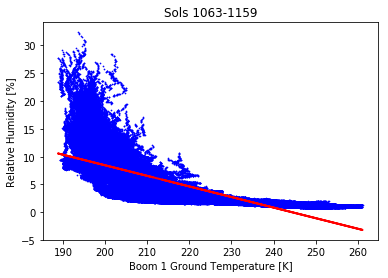

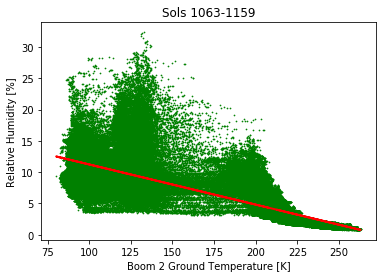

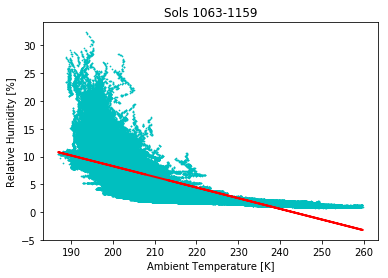

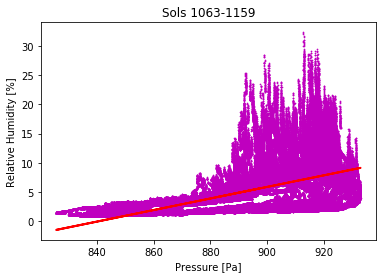

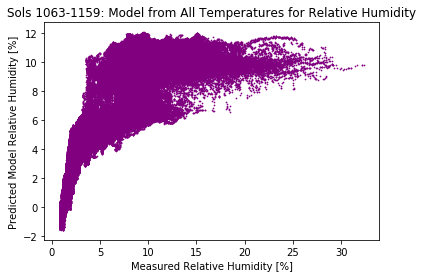

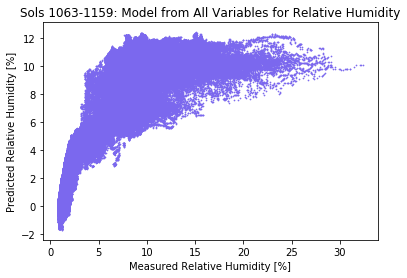

1063-1159 Sols
R^2 for Boom 1 Temperature: 0.649017452335151
R^2 for Boom 2 Temperature: 0.6604431627299048
R^2 for Ambient Temperature: 0.644037512966268
R^2 for Pressure: 0.340850006939226
R^2 for All Temperatures: 0.7210362075616094
R^2 for All: 0.741283654906946


In [7]:
#1063-1159 Sols
sol_epoch_starts = np.array([1063, 1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
hum_pred = lm.predict(ground_temp_1_test)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)
f1_temp = plt.figure()
plt.plot(ground_temp_1_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'b')
plt.plot(ground_temp_1_test, hum_pred, color='red', linewidth=2)
plt.title('Sols 1063-1159')
plt.xlabel('Boom 1 Ground Temperature [K]')
plt.ylabel('Relative Humidity [%]')
plt.show()
f1_temp.savefig("boom1_local_air_temp", bbox_inches='tight', dpi=600)



ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
hum_pred = lm.predict(ground_temp_2_test)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)
f2_temp = plt.figure()
plt.plot(ground_temp_2_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'g')
plt.plot(ground_temp_2_test, hum_pred, color='red', linewidth=2)
plt.title('Sols 1063-1159')
plt.xlabel('Boom 2 Ground Temperature [K]')
plt.ylabel('Relative Humidity [%]')
plt.show()
f2_temp.savefig("boom2_local_air_temp", bbox_inches='tight', dpi=600)



amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
hum_pred = lm.predict(amb_temp_test)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)

accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)
f3_amb_temp = plt.figure()
plt.plot(amb_temp_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'c')
plt.plot(amb_temp_test, hum_pred, color='red', linewidth=2)
plt.title('Sols 1063-1159')
plt.xlabel('Ambient Temperature [K]')
plt.ylabel('Relative Humidity [%]')
plt.show()
f3_amb_temp.savefig("amb_temp", bbox_inches='tight', dpi=600)
press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)
hum_pred = lm.predict(press_test)

f4_press = plt.figure()
plt.plot(press_test, rel_hum_test, linestyle='', marker = 'o', markersize=0.7, color = 'm')
plt.plot(press_test, hum_pred, color='red', linewidth=2)
plt.title('Sols 1063-1159')
plt.xlabel('Pressure [Pa]')
plt.ylabel('Relative Humidity [%]')
plt.show()
f4_press.savefig("pressure", bbox_inches='tight', dpi=600)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
hum_pred = lm.predict(all_temp_x_test)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)
# pred = lm.predict(hum_pred)
plt.rcParams['agg.path.chunksize'] = 20000
f5_alltemps = plt.figure()
plt.plot(rel_hum_test, hum_pred, linestyle='', marker = 'o', markersize=0.7, color = 'purple')
# plt.plot(rel_hum_test, pred, color='red', linewidth=2)
plt.title('Sols 1063-1159: Model from All Temperatures for Relative Humidity')
plt.ylabel('Predicted Model Relative Humidity [%]')
plt.xlabel('Measured Relative Humidity [%]')
plt.show()
f5_alltemps.savefig("alltemps_x", bbox_inches='tight', dpi=600)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
hum_pred = lm.predict(all_test)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)
plt.rcParams['agg.path.chunksize'] = 20000
f6_all = plt.figure()
plt.plot(rel_hum_test, hum_pred, linestyle='', marker = 'o', markersize=0.7, color = 'mediumslateblue')
# plt.plot(rel_hum_test, pred, color='red', linewidth=2)
plt.title('Sols 1063-1159: Model from All Variables for Relative Humidity')
plt.ylabel('Predicted Relative Humidity [%]')
plt.xlabel('Measured Relative Humidity [%]')
plt.show()
f6_all.savefig("all_x", bbox_inches='tight', dpi=600)

print("1063-1159 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

In [8]:
print(r2_temp1s, temp1_accuracies, r2_temp2s, temp2_accuracies, r2_ambtemps, ambtemp_accuracies, r2_alltemps, alltemps_accuracies, r2_pressures, press_accuracies, r2_alls, all_accuracies)

[0.608591468035422, 0.7780524600334561, 0.6297613811437551, 0.7266205965891404, 0.7006012882021174, 0.5751796271984406, 0.5647309303891207, 0.6368138633222762, 0.7293562515187603, 0.649017452335151] [0.5775130084264942, 0.7784553737973955, 0.6772839800361711, 0.7334026873852226, 0.701230684219033, 0.5669109126423637, 0.5705609578378099, 0.6157915012535651, 0.7271964490725586, 0.6577551054326909] [0.7253220904412425, 0.7857673344938957, 0.7197980282879539, 0.7182844872239051, 0.7106241527597474, 0.5277207670020225, 0.6261518278552595, 0.7733826929419856, 0.7492653347175564, 0.6604431627299048] [0.7273187092900053, 0.7854490245517289, 0.7540812991210603, 0.7232635486132208, 0.7137520716123156, 0.5162651903770012, 0.6208334491462746, 0.7684181561976574, 0.7488858875704931, 0.6695332654336279] [0.579687781461556, 0.8059427540060963, 0.6763643928758349, 0.7488852421926011, 0.6930407077531203, 0.54917509899962, 0.5548744191208882, 0.6703595000910605, 0.7609411559289344, 0.644037512966268] [0

In [2]:
r2_temp1s = [0.608591468035422, 0.7780524600334561, 0.6297613811437551, 0.7266205965891404, 0.7006012882021174, 0.5751796271984406, 0.5647309303891207, 0.6368138633222762, 0.7293562515187603, 0.649017452335151]
temp1_accuracies = [0.5775130084264942, 0.7784553737973955, 0.6772839800361711, 0.7334026873852226, 0.701230684219033, 0.5669109126423637, 0.5705609578378099, 0.6157915012535651, 0.7271964490725586, 0.6577551054326909]
r2_temp2s = [0.7253220904412425, 0.7857673344938957, 0.7197980282879539, 0.7182844872239051, 0.7106241527597474, 0.5277207670020225, 0.6261518278552595, 0.7733826929419856, 0.7492653347175564, 0.6604431627299048]
temp2_accuracies = [0.7273187092900053, 0.7854490245517289, 0.7540812991210603, 0.7232635486132208, 0.7137520716123156, 0.5162651903770012, 0.6208334491462746, 0.7684181561976574, 0.7488858875704931, 0.6695332654336279]
r2_ambtemps = [0.579687781461556, 0.8059427540060963, 0.6763643928758349, 0.7488852421926011, 0.6930407077531203, 0.54917509899962, 0.5548744191208882, 0.6703595000910605, 0.7609411559289344, 0.644037512966268]
ambtemp_accuracies = [0.561429535014186, 0.8053650172980267, 0.7168747194047624, 0.7540097939871565, 0.6933582269069607, 0.5428994235516622, 0.5579785497326658, 0.6422141022279997, 0.7585380959344084, 0.65210415158784]
r2_alltemps = [0.732016063124501, 0.8155162196018726, 0.7195087373612029, 0.7736953282509502, 0.7822235696781235, 0.6091707426058763, 0.6585126638203516, 0.7810616946857482, 0.8080321396033778, 0.7210362075616094]
alltemps_accuracies = [0.7266685579493631, 0.8150924530496848, 0.754291767615253, 0.78007161896674, 0.783129597922606, 0.5969180121827017, 0.6569256223426905, 0.7708798185382898, 0.8077425553260509, 0.730120030771239]
r2_pressures = [-0.16808231688484815, 0.1130024787741896, -0.09351806979996109, 0.4096147808118172, 0.38838825216393225, -0.09886447948533053, 0.13650502398453473, -0.26395549494564713, 0.2405428757221361, 0.340850006939226]
press_accuracies = [-0.029292459284214756, 0.11837212609603187, 0.06182312929856093, 0.439807541438196, 0.409578732699999, -0.050364357003487514, 0.13591027913932008, -0.1217682095875603, 0.2514250842525464, 0.353099062357245]
r2_alls = [0.7349206545334027, 0.8146709493994164, 0.7415246257171251, 0.7797936574194793, 0.7817891293818681, 0.6166995528216788, 0.6605646077212611, 0.7883771191282981, 0.8069819120321886, 0.741283654906946]
all_accuracies = [0.73092787165723, 0.8142324336063692, 0.7669362281063445, 0.7860439759654456, 0.7811608034925994, 0.5987481266920774, 0.6594323237474635, 0.7767970151066454, 0.805968679002412, 0.7491681635795495]

In [4]:
#1160-1293 Sols
sol_epoch_starts = np.array([1160, 1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)


print("1160-1293 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

1160-1293 Sols
R^2 for Boom 1 Temperature: 0.6405083883258287
R^2 for Boom 2 Temperature: 0.6612171010441436
R^2 for Ambient Temperature: 0.6035661783149056
R^2 for Pressure: -0.031102853175117583
R^2 for All Temperatures: 0.7069940691680958
R^2 for All: 0.7017149628616675


In [5]:
r2_temp1s = 
temp1_accuracies = 
r2_temp2s = 
temp2_accuracies = 
r2_ambtemps = 
ambtemp_accuracies = 
r2_alltemps = 
alltemps_accuracies = 
r2_pressures = 
press_accuracies = 
r2_alls = 
all_accuracies = 

[0.608591468035422, 0.7780524600334561, 0.6297613811437551, 0.7266205965891404, 0.7006012882021174, 0.5751796271984406, 0.5647309303891207, 0.6368138633222762, 0.7293562515187603, 0.649017452335151, 0.6405083883258287] [0.5775130084264942, 0.7784553737973955, 0.6772839800361711, 0.7334026873852226, 0.701230684219033, 0.5669109126423637, 0.5705609578378099, 0.6157915012535651, 0.7271964490725586, 0.6577551054326909, 0.6411980573550151] [0.7253220904412425, 0.7857673344938957, 0.7197980282879539, 0.7182844872239051, 0.7106241527597474, 0.5277207670020225, 0.6261518278552595, 0.7733826929419856, 0.7492653347175564, 0.6604431627299048, 0.6612171010441436] [0.7273187092900053, 0.7854490245517289, 0.7540812991210603, 0.7232635486132208, 0.7137520716123156, 0.5162651903770012, 0.6208334491462746, 0.7684181561976574, 0.7488858875704931, 0.6695332654336279, 0.6628779515762101] [0.579687781461556, 0.8059427540060963, 0.6763643928758349, 0.7488852421926011, 0.6930407077531203, 0.54917509899962, 0

In [3]:
r2_temp1s = [0.608591468035422, 0.7780524600334561, 0.6297613811437551, 0.7266205965891404, 0.7006012882021174, 0.5751796271984406, 0.5647309303891207, 0.6368138633222762, 0.7293562515187603, 0.649017452335151, 0.6405083883258287]
temp1_accuracies = [0.5775130084264942, 0.7784553737973955, 0.6772839800361711, 0.7334026873852226, 0.701230684219033, 0.5669109126423637, 0.5705609578378099, 0.6157915012535651, 0.7271964490725586, 0.6577551054326909, 0.6411980573550151]
r2_temp2s = [0.7253220904412425, 0.7857673344938957, 0.7197980282879539, 0.7182844872239051, 0.7106241527597474, 0.5277207670020225, 0.6261518278552595, 0.7733826929419856, 0.7492653347175564, 0.6604431627299048, 0.6612171010441436]
temp2_accuracies = [0.7273187092900053, 0.7854490245517289, 0.7540812991210603, 0.7232635486132208, 0.7137520716123156, 0.5162651903770012, 0.6208334491462746, 0.7684181561976574, 0.7488858875704931, 0.6695332654336279, 0.6628779515762101]
r2_ambtemps = [0.579687781461556, 0.8059427540060963, 0.6763643928758349, 0.7488852421926011, 0.6930407077531203, 0.54917509899962, 0.5548744191208882, 0.6703595000910605, 0.7609411559289344, 0.644037512966268, 0.6035661783149056]
ambtemp_accuracies = [0.561429535014186, 0.8053650172980267, 0.7168747194047624, 0.7540097939871565, 0.6933582269069607, 0.5428994235516622, 0.5579785497326658, 0.6422141022279997, 0.7585380959344084, 0.65210415158784, 0.604049971927461]
r2_alltemps = [0.732016063124501, 0.8155162196018726, 0.7195087373612029, 0.7736953282509502, 0.7822235696781235, 0.6091707426058763, 0.6585126638203516, 0.7810616946857482, 0.8080321396033778, 0.7210362075616094, 0.7069940691680958]
alltemps_accuracies = [0.7266685579493631, 0.8150924530496848, 0.754291767615253, 0.78007161896674, 0.783129597922606, 0.5969180121827017, 0.6569256223426905, 0.7708798185382898, 0.8077425553260509, 0.730120030771239, 0.7079867138552987]
r2_pressures = [-0.16808231688484815, 0.1130024787741896, -0.09351806979996109, 0.4096147808118172, 0.38838825216393225, -0.09886447948533053, 0.13650502398453473, -0.26395549494564713, 0.2405428757221361, 0.340850006939226, -0.031102853175117583]
press_accuracies = [-0.029292459284214756, 0.11837212609603187, 0.06182312929856093, 0.439807541438196, 0.409578732699999, -0.050364357003487514, 0.13591027913932008, -0.1217682095875603, 0.2514250842525464, 0.353099062357245, -0.03318943402999319]
r2_alls = [0.7349206545334027, 0.8146709493994164, 0.7415246257171251, 0.7797936574194793, 0.7817891293818681, 0.6166995528216788, 0.6605646077212611, 0.7883771191282981, 0.8069819120321886, 0.741283654906946, 0.7017149628616675]
all_accuracies = [0.73092787165723, 0.8142324336063692, 0.7669362281063445, 0.7860439759654456, 0.7811608034925994, 0.5987481266920774, 0.6594323237474635, 0.7767970151066454, 0.805968679002412, 0.7491681635795495, 0.7027204748303382]

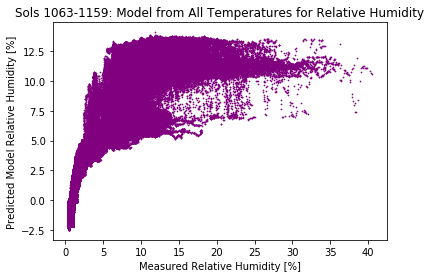

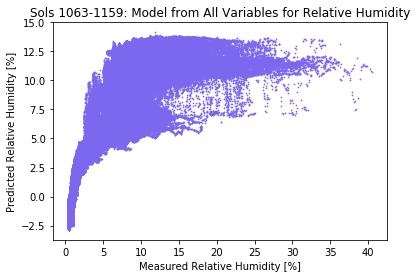

1294-1417 Sols
R^2 for Boom 1 Temperature: 0.5355992810692238
R^2 for Boom 2 Temperature: 0.7070948326174953
R^2 for Ambient Temperature: 0.5250506025530047
R^2 for Pressure: -0.745217577512605
R^2 for All Temperatures: 0.7122975612920699
R^2 for All: 0.7143333668101766


In [4]:
#1294-1417 Sols
sol_epoch_starts = np.array([1294, 1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
hum_pred = lm.predict(all_temp_x_test)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)
# pred = lm.predict(hum_pred)
plt.rcParams['agg.path.chunksize'] = 20000
f5_alltemps = plt.figure()
plt.plot(rel_hum_test, hum_pred, linestyle='', marker = 'o', markersize=0.7, color = 'purple')
# plt.plot(rel_hum_test, pred, color='red', linewidth=2)
plt.title('Sols 1063-1159: Model from All Temperatures for Relative Humidity')
plt.ylabel('Predicted Model Relative Humidity [%]')
plt.xlabel('Measured Relative Humidity [%]')
plt.show()
f5_alltemps.savefig("alltemps_x", bbox_inches='tight', dpi=600)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
hum_pred = lm.predict(all_test)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)
plt.rcParams['agg.path.chunksize'] = 20000
f6_all = plt.figure()
plt.plot(rel_hum_test, hum_pred, linestyle='', marker = 'o', markersize=0.7, color = 'mediumslateblue')
# plt.plot(rel_hum_test, pred, color='red', linewidth=2)
plt.title('Sols 1063-1159: Model from All Variables for Relative Humidity')
plt.ylabel('Predicted Relative Humidity [%]')
plt.xlabel('Measured Relative Humidity [%]')
plt.show()
f6_all.savefig("all_x", bbox_inches='tight', dpi=600)


print("1294-1417 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

In [ ]:
#1418-1514 Sols
sol_epoch_starts = np.array([1418, 1515, 1649, 1773, 1870, 2004, 2128, 2225, 2359])

data_all = []
for epoch_index in range(num_epochs):                            
    epoch_file_name = get_epoch_name(epoch_index)
    for sol_number in range(sol_epoch_starts[epoch_index], sol_epoch_starts[epoch_index+1]):
        sol_file_name = get_sol_name(sol_number)
        entire_url = base_url + epoch_file_name + '/' + sol_file_name
        entire_list = listFD(entire_url)
        for file_name in entire_list:
            if ('RMD' in file_name) and ('TAB' in file_name):
                final_file_name = file_name
                r = http.request('GET', final_file_name)
                data = r.data.decode('utf-8')
                data = data.split('\n')
                data_all += [line.split(',') for line in data]
                break

df = pd.DataFrame(data_all)
df = df[[0, 11, 12, 13, 14, 15, 16, 30, 31, 32, 37, 38, 39]]
df = df.replace('    UNK', np.nan)
df = df.dropna()
df[[11,13,15,30,37]] = df[[11,13,15,30,37]].apply(pd.to_numeric)

name_dict = {11:'boom1_local_air_temperature', 30: 'local_relative_humidity', 13:'boom2_local_air_temperature', 37: 'pressure', 15: 'ambient_temperature'}
new_df = df.rename(name_dict, axis = 1)
rel_humidity = new_df[['local_relative_humidity']].values.reshape(-1,1)

#5-fold cross validation
ground_temp_1 = new_df[['boom1_local_air_temperature']].values.reshape(-1,1) # values converts it into a numpy array
ground_temp_1_train, ground_temp_1_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_1, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_1_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_1, rel_humidity, cv=5)
r2_temp1 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_1, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp1_accuracies.append(accuracy)
r2_temp1s.append(r2_temp1)


ground_temp_2 = new_df[['boom2_local_air_temperature']].values.reshape(-1,1) 
ground_temp_2_train, ground_temp_2_test, rel_hum_train, rel_hum_test = train_test_split(ground_temp_2, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(ground_temp_2_train, rel_hum_train)
scores = cross_val_score(model, ground_temp_2, rel_humidity, cv=5)
r2_temp2 = np.average(scores)
predictions = cross_val_predict(model, ground_temp_2, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
temp2_accuracies.append(accuracy)
r2_temp2s.append(r2_temp2)


amb_temp = new_df[['ambient_temperature']].values.reshape(-1,1)
amb_temp_train, amb_temp_test, rel_hum_train, rel_hum_test = train_test_split(amb_temp, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(amb_temp_train, rel_hum_train)
scores = cross_val_score(model, amb_temp, rel_humidity, cv=5)
r2_amb_temp = np.average(scores)
predictions = cross_val_predict(model, amb_temp, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
ambtemp_accuracies.append(accuracy)
r2_ambtemps.append(r2_amb_temp)

press = new_df[['pressure']].values.reshape(-1,1) 
press_train, press_test, rel_hum_train, rel_hum_test = train_test_split(press, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(press_train, rel_hum_train)
scores = cross_val_score(model, press, rel_humidity, cv=5)
r2_press = np.average(scores)
predictions = cross_val_predict(model, press, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
press_accuracies.append(accuracy)
r2_pressures.append(r2_press)

all_temp_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature']].values
all_temp_x_train, all_temp_x_test, rel_hum_train, rel_hum_test = train_test_split(all_temp_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_temp_x_train, rel_hum_train)
scores = cross_val_score(model, all_temp_x, rel_humidity, cv=5)
r2_all_temps = np.average(scores)
hum_pred = lm.predict(all_temp_x_test)
predictions = cross_val_predict(model, all_temp_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
alltemps_accuracies.append(accuracy)
r2_alltemps.append(r2_all_temps)
# pred = lm.predict(hum_pred)
plt.rcParams['agg.path.chunksize'] = 20000
f5_alltemps = plt.figure()
plt.plot(rel_hum_test, hum_pred, linestyle='', marker = 'o', markersize=0.7, color = 'purple')
# plt.plot(rel_hum_test, pred, color='red', linewidth=2)
plt.title('Sols 1063-1159: Model from All Temperatures for Relative Humidity')
plt.ylabel('Predicted Model Relative Humidity [%]')
plt.xlabel('Measured Relative Humidity [%]')
plt.show()
f5_alltemps.savefig("alltemps_x", bbox_inches='tight', dpi=600)


all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
all_train, all_test, rel_hum_train, rel_hum_test = train_test_split(all_x, rel_humidity, test_size=0.3, random_state=42)
model = lm.fit(all_train, rel_hum_train)
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
r2_all = np.average(scores)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
hum_pred = lm.predict(all_test)
all_accuracies.append(accuracy)
r2_alls.append(r2_all)
plt.rcParams['agg.path.chunksize'] = 20000
f6_all = plt.figure()
plt.plot(rel_hum_test, hum_pred, linestyle='', marker = 'o', markersize=0.7, color = 'mediumslateblue')
# plt.plot(rel_hum_test, pred, color='red', linewidth=2)
plt.title('Sols 1063-1159: Model from All Variables for Relative Humidity')
plt.ylabel('Predicted Relative Humidity [%]')
plt.xlabel('Measured Relative Humidity [%]')
plt.show()
f6_all.savefig("all_x", bbox_inches='tight', dpi=600)


print("1418-1514 Sols")
print("R^2 for Boom 1 Temperature:", r2_temp1)               
print("R^2 for Boom 2 Temperature:", r2_temp2)
print("R^2 for Ambient Temperature:", r2_amb_temp)
print("R^2 for Pressure:", r2_press)
print("R^2 for All Temperatures:", r2_all_temps)
print("R^2 for All:", r2_all)

In [ ]:
print(np.average(r2_temp1s), 'temp1')
print(np.average(temp1_accuracies), 'temp1 accuracies')

print(np.average(r2_temp2s), 'temp2')
print(np.average(temp2_accuracies), 'temp2 accuracies')

print(np.average(r2_ambtemps), 'ambtemp')
print(np.average(ambtemp_accuracies), 'ambtemp accuracies')

print(np.average(r2_pressures), 'pressure')
print(np.average(press_accuracies), 'pressure accuracies')

print(np.average(r2_alltemps), 'alltemps')
print(np.average(alltemps_accuracies), 'alltemp accuracies')

print(np.average(r2_alls), 'alls')
print(np.average(all_accuracies), 'all accuracies')

In [80]:
all_x = new_df[['boom1_local_air_temperature','boom2_local_air_temperature','ambient_temperature', 'pressure']].values
scores = cross_val_score(model, all_x, rel_humidity, cv=5)
predictions = cross_val_predict(model, all_x, rel_humidity, cv=5)
accuracy = metrics.r2_score(rel_humidity, predictions)
all_accuracies.append(accuracy)
r2_alls.append(np.average(scores))

NameError: name 'all_accuracies' is not defined